# Solving time dependent systems

## Stochastic semi-linear heat equation

We will solve 

\begin{align}
&du = (\Delta u + f(u))dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

where $\frac{dW_t}{dt}$ is space time white noise. We use an isemi-mplicit EM method with step size $h$

\begin{align}
&u_0 = g(x) \\
&u_{n+1} = u_n + h \Delta u_{n+1} + h f(u_n) + \Delta W_n
\end{align}
where 
$$
\Delta W_n \sim \mathcal{N}(0, h I)
$$


Hence 
\begin{align}
&(-h \Delta + I )u_{n+1} = u_n + hf(u_n) + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}

At each step we solve

\begin{align}
[(-h \Delta + I )u_{n+1}, \psi] = [u_n,\psi] + h[f(u_n), \psi]+ \sqrt{h}[\Delta \xi_n, \psi]
\end{align}


We will consider the Allen Cahn equation

\begin{align}
&du = (\nu \Delta u + u - u^3)dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

This leads to the following disretization:

\begin{align}
&(-h \nu\Delta + (1-h)I )u_{n+1} = u_n - hu_n^3 + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}




In [90]:
import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy


from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

import time

from tqdm import tqdm


C:\Users\Matthieu\AppData\Local\Temp\ipykernel_10036\1995607006.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [91]:
def save_plots(prediction, noise_results, inital_condition, T, folder_name, n_frames = 1):
    import os
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    prediction = prediction[::n_frames]

    centers, noise = noise_results



    n_frames = prediction.shape[0] 
    h = T/n_frames

    #print(T, n_frames, h)
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    ax[0].plot(x, inital_condition)
    ax[0].set_title('Initial condition')
    ax[0].set_xlabel(r'$x$')
    ax[0].set_ylabel(r'$g(x)$')

    for i in tqdm(range(n_frames)):
        ax[1].cla()
        ax[2].cla()

        ax[1].set_ylim(jnp.min(prediction) - 0.1, jnp.max(prediction) + 0.1)
        ax[2].set_ylim(jnp.min(noise) - 0.1, jnp.max(noise) + 0.1)

        ax[1].set_xlabel(r'$x$')
        ax[2].set_xlabel(r'$x$')


        ax[1].set_ylabel(r'$u^\dagger(x)$')
        ax[2].set_ylabel(r'$\xi (x)$')

        ax[1].plot(x, prediction[i], label = "Kernel")
        ax[1].legend()
        ax[1].set_title('Solution')

        ax[2].plot(centers, noise[i])
        ax[2].set_title('White noise')

        # Create a title for the whole plot
        fig.suptitle(r'Solution at time ${:03f}$'.format(i*h))

        # Save the plot
        fig.savefig(folder_name + 'solution_{:03d}.png'.format(i+1))

In [92]:
from utils_optim import kernel_linear_solver

In [93]:
# Define the domain of the problem
lower = 0.0
upper = 1.0
L = upper - lower
x = jnp.linspace(0, 1, 1000)
boundary = jnp.array([[lower, upper]]).T
boundary_conditions = jnp.zeros(shape = (2, )) # Dirichlet boundary conditions
domain = jnp.array([lower, upper])


In [94]:
n_meas = 700
m_tool = measurement_tool(domain, n_meas)

# Initial condition

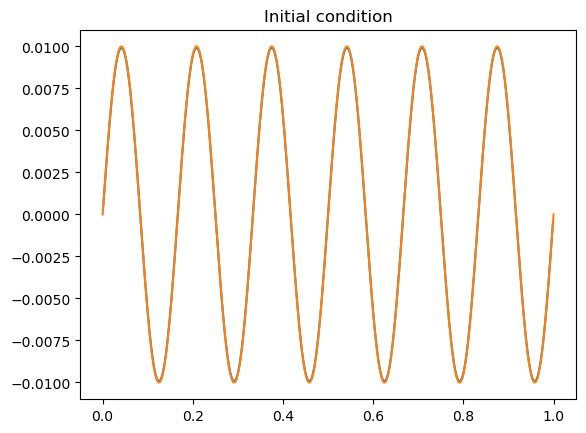

In [95]:
u0 = lambda x: jnp.sin(12*jnp.pi*x)*0.01 #jnp.cos(2*jnp.pi*x)*jnp.cos(4*jnp.pi*x)*jnp.cos(6*jnp.pi*x)*jnp.sin(12*jnp.pi*x)*0.1
g_init = u0(x) 

y_init = m_tool.project(m_tool.evaluate_at_roots(u0))

plt.plot(m_tool.centers, y_init)
plt.plot(x, g_init)
plt.title('Initial condition')
plt.show()

# Integrating

In [96]:
stiffness_matrix = m_tool.stiffess_matrix
L_2 = m_tool.L_2

In [97]:
def implicit_Euler_semilinear(T, h, tau, m_tool, linear_solver, y_init,sigma, reg, key, record = False):
    L_stiff = m_tool.L_stiff
    L_L2 = scipy.linalg.cholesky(m_tool.L_2)
    N_tent =m_tool.N
   

    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)
    y = y_init

    noise = []
    history = []
    for i in range(N):
        key, subkey = random.split(key)
        # Sample from the space time white noise
        xi =  sigma*L_L2@random.normal(subkey, (N_tent,))
        
        # Create the right hand side
        rhs = y +jnp.sqrt(h)*xi

        # Solve the linear system
        linear_solver.solve(rhs, reg, L_stiff, compute_residuals = False)

        # Evaluate the non linearity
        root_nl = tau(linear_solver.evaluate_solution_predef(m_tool.root_psi))
        # Project the non linearity
        proj_nl = m_tool.project(root_nl)
        #print(proj_nl.shape, y.shape, xi.shape)


        # Update the rhs
        y = linear_solver.evaluate_solution_psi() + h*proj_nl    
        

        if record:
            history.append(linear_solver.c)    
            noise.append(xi)
        #print(y.shape)
    if record:
        return y, linear_solver, jnp.stack(history), jnp.stack(noise)
    return y, linear_solver 

In [98]:
length_scale = 0.1
bc = jnp.zeros(shape = (2, )) 
nu = 1e-5
tau = lambda x: -x**3

In [99]:
h = 1/300#1e-3
sigma = 0.01
T= 10.0


linear_solver = kernel_linear_solver(length_scale, m_tool.psi_matrix, m_tool.root_psi, boundary, bc, h*nu)
root_identity = (1-h)*jnp.ones_like(m_tool.root_psi)


start = time.time()
linear_solver.build_matrices(root_identity)
linear_solver.create_K_psi()
linear_solver.create_K_eval(x)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))


Time to build the matrices 2.32478


In [100]:
start = time.time()
y, linear_solver, c_kernel_history, white_noise = implicit_Euler_semilinear(T, h, tau, m_tool, linear_solver, y_init, sigma, None, random.key(1), record = True)
end = time.time()
print('Time taken:', end - start)

Time taken: 32.1245231628418


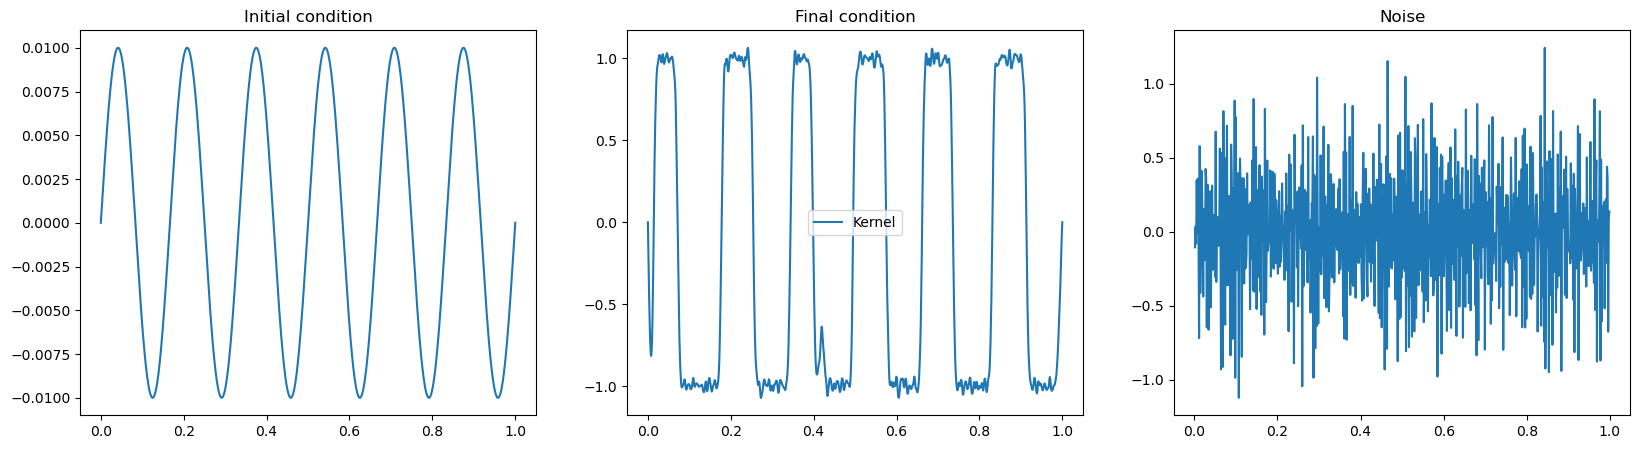

In [101]:
# Plot 2 figures with the initial condition and the final condition

fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax[0].plot(x, g_init)
ax[0].set_title('Initial condition')
ax[1].plot(x, linear_solver.evaluate_solution(x), label= "Kernel")
ax[1].legend()
ax[1].set_title('Final condition')
ax[2].set_title('Noise')
ax[2].plot(m_tool.centers, white_noise[0])
plt.show()

In [102]:
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

100%|██████████| 300/300 [01:05<00:00,  4.56it/s]


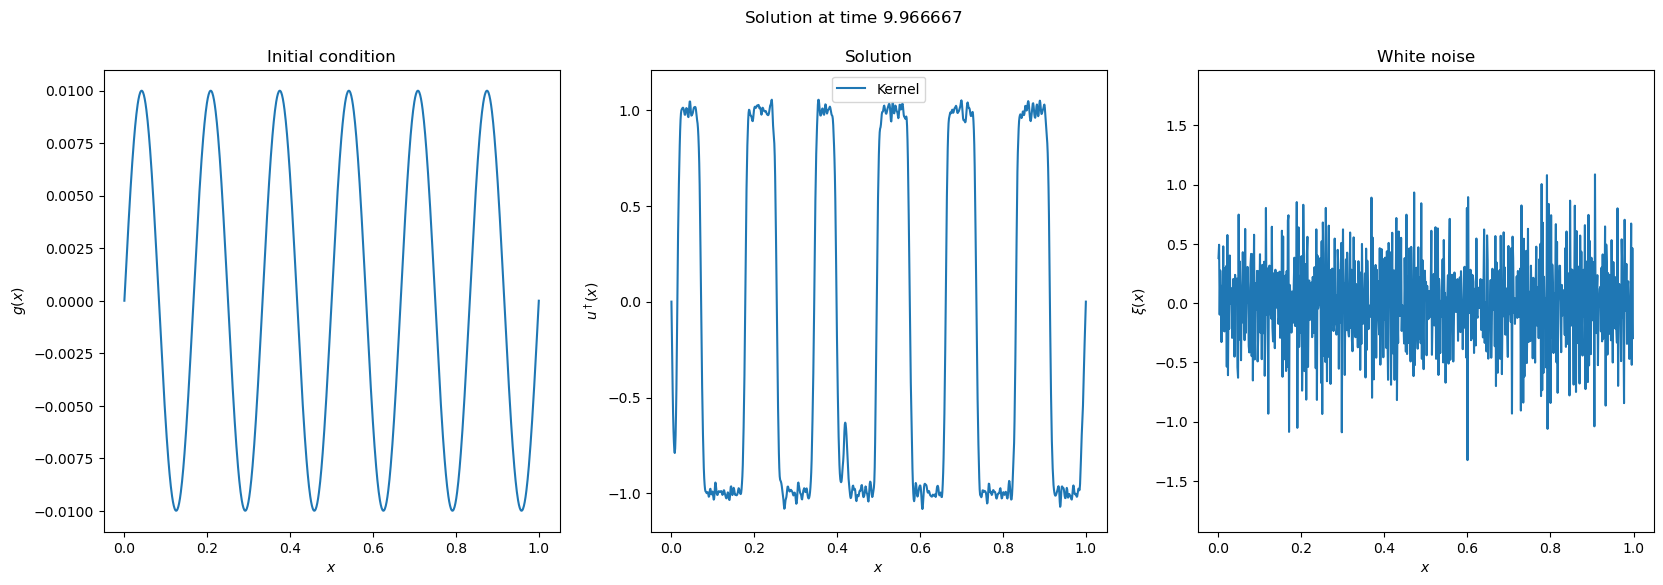

In [103]:
save_plots(pred_kernel, (m_tool.centers, white_noise), g_init, T, 'figures/allen_cahn_8/', n_frames = 10)